**Goal**    
Exploration of various metrics and behaviours for different model selection criteria

In [57]:
import sys
sys.path.insert(1, "..")
import pprint
import gpytorch
import torch
import numpy as np
import metrics
import copy
import configparser
from experiment_functions import Experiment
from GaussianProcess import ExactGPModel
from globalParams import options, hyperparameter_limits
import gpytorch
from helpFunctions import get_string_representation_of_kernel as gsr
from helpFunctions import clean_kernel_expression
from helpFunctions import get_kernels_in_kernel_expression, get_full_kernels_in_kernel_expression
from helpFunctions import amount_of_base_kernels
from itertools import product
import json
from kernelSearch import *
from matplotlib import pyplot as plt
from metrics import *
from multiprocessing import Pool
import numpy as np
import os
import pdb
import pickle
import random
import tikzplotlib
import time
import torch
from tqdm import tqdm
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch

In [58]:
def random_reinit(model):
    for i, (param, limit) in enumerate(zip(model.parameters(), [{"Noise": hyperparameter_limits["Noise"]},*[hyperparameter_limits[kernel] for kernel in get_full_kernels_in_kernel_expression(model.covar_module)]])):
        covar_text = gsr(model.covar_module)
        param_name = list(limit.keys())[0]
        new_param_value = torch.randn_like(param) * (limit[param_name][1] - limit[param_name][0]) + limit[param_name][0]
        param.data = new_param_value


def optimize_hyperparameters(model, likelihood, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """
    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    # Use kwargs if not None, otherwise use the default values
    train_x = kwargs.get("train_x", model.train_inputs[0])
    train_y = kwargs.get("train_y", model.train_targets)

    # Define the negative log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Set up the PyGRANSO optimizer
    opts = pygransoStruct()
    opts.torch_device = torch.device('cpu')
    nvar = getNvarTorch(model.parameters())
    opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
    opts.opt_tol = 1e-10
    opts.limited_mem_size = 100
    opts.globalAD = True
    opts.quadprog_info_msg = False
    opts.print_level = 0
    opts.halt_on_linesearch_bracket = False
    opts.double_precision = False

    # Define the objective function
    def objective_function(model):
        output = model(train_x)
        loss = -mll(output, train_y)
        log_p = metrics.log_normalized_prior(model)
        loss -= log_p
        return [loss, None, None]

    best_model_state_dict = model.state_dict()
    best_likelihood_state_dict = likelihood.state_dict()

    random_restarts = 5
    best_f = np.inf
    for restart in range(random_restarts):
        # Train the model using PyGRANSO
        soln = pygranso(var_spec=model, combined_fn=objective_function, user_opts=opts)
        if soln.final.f < best_f:
            best_f = soln.final.f
            best_model_state_dict = model.state_dict()
            best_likelihood_state_dict = likelihood.state_dict()
        print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f}")
        random_reinit(model)

    model.load_state_dict(best_model_state_dict)
    likelihood.load_state_dict(best_likelihood_state_dict)

    loss = -mll(model(train_x), train_y)
    log_p = metrics.log_normalized_prior(model)
    loss -= log_p

    print(f"post training (best): {list(model.named_parameters())} w. loss: {soln.best.f}")
    print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f}")
    print(torch.autograd.grad(loss, [p for p in model.parameters()], retain_graph=True, create_graph=True, allow_unused=True))
    # Return the trained model
    return loss, model, likelihood

def get_std_points(mu, K):
    x, y = np.mgrid[-3:3:.1, -3:3:.1]
    rv = multivariate_normal(mu, K)
    L = np.linalg.cholesky(K)

    data = np.dstack((x, y))
    z = rv.pdf(data)

    # Drawing the unit circle
    # x^2 + y^2 = 1
    precision = 50
    unit_x = torch.cat([torch.linspace(-1, 1, precision), torch.linspace(-1, 1, precision)])
    unit_y = torch.cat([torch.sqrt(1 - torch.linspace(-1, 1, precision)**2), -torch.sqrt(1 - torch.linspace(-1, 1, precision)**2)])

    new_unit_x = list()
    new_unit_y = list()

    for tx, ty in zip(unit_x, unit_y):
        res = np.array([tx, ty]) @ L
        new_unit_x.append(mu[0] + 2*res[0])
        new_unit_y.append(mu[1] + 2*res[1])
    return new_unit_x, new_unit_y

In [59]:
# from metrics.py
# Used to generate the parameter prior for the specific class of GP kernel and calculate the log propability of this specific parametrization
#metrics.prior_distribution()
#metrics.log_normalized_prior()

# Definitions

In [60]:
# Global name
generating_model_GP = ""
evaluating_GP_model = ""
# timestamp in yyyy-mm-dd-hh-mm-ss
timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")

log_path = f"logs/{timestamp}_{evaluating_GP_model}/"

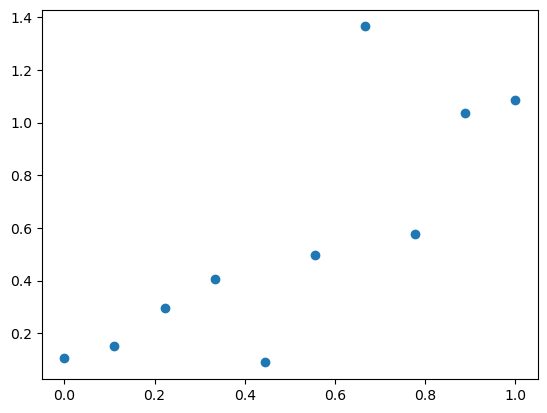

In [74]:
# Data
torch.manual_seed(42)
END = 1
COUNT = 10
train_x = torch.linspace(0, END, COUNT)
train_y = torch.linspace(0, END, COUNT)
train_y += torch.randn(train_x.size()) * torch.sqrt(torch.tensor(0.1))
plt.plot(train_x, train_y, "o")

# Model definition

In [62]:
kernel = gpytorch.kernels.RBFKernel()

In [63]:
# Simplest GP possible. SE with constant sigma_f 
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-30))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Training

In [64]:
loss, model, likelihood = optimize_hyperparameters(model, likelihood)

post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-2.4345], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.5014]], requires_grad=True))] w. loss: 0.9174181222915649
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-2.4345], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.5014]], requires_grad=True))] w. loss: 0.9174181222915649
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-2.4345], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.5014]], requires_grad=True))] w. loss: 0.9174181222915649
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-2.4345], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.5014]], requires_grad=True))] w. loss: 0.9174181222915649
post trainin

In [65]:
model(train_x)

MultivariateNormal(loc: torch.Size([10]))

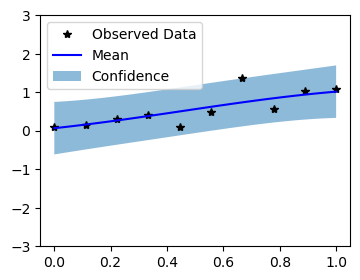

In [66]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    a = model(test_x)
    observed_pred = likelihood(a)
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# Laplace

In [67]:
model.train()
likelihood.train()

lap, lap_log = metrics.calculate_laplace(model, -loss*COUNT, with_prior=True, param_punish_term="BIC")
print(lap)
print(lap_log)

tensor(-13.7794, grad_fn=<AddBackward0>)
{'neg MLL': tensor(9.1742, dtype=torch.float32, grad_fn=<NegBackward0>), 'punish term': tensor(-4.6052), 'laplace without replacement': tensor(-7.7858, grad_fn=<SubBackward0>), 'num_replaced': tensor(2), 'parameter list': ['likelihood.noise_covar.raw_noise', 'covar_module.raw_lengthscale'], 'Jacobian': (tensor([-3.8072e-06], dtype=torch.float32, grad_fn=<AddBackward0>), tensor([[-8.9407e-07]], dtype=torch.float32, grad_fn=<AddBackward0>)), 'parameter values': tensor([[-2.4345],
        [ 0.5014]], dtype=torch.float32), 'corrected Hessian': tensor([[628.3185,   0.0000],
        [  0.0000, 628.3185]]), 'diag(constructed eigvals)': tensor([628.3185, 628.3185]), 'original symmetrized Hessian': tensor([[3.7372, 0.0875],
        [0.0875, 0.6595]]), 'prior mean': tensor([[-3.5164],
        [-0.2122]]), 'diag(prior var)': tensor([12.8388,  3.5704]), 'likelihood approximation': tensor(-13.7794, grad_fn=<AddBackward0>), 'Derivative time': 0.00157642364501

/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for i, val in enumerate(vals)]))


# AIC

In [70]:
model.train()
likelihood.train()

aic, aic_log = metrics.calculate_AIC(-loss, len(list(model.parameters())))
print(aic)
print(aic_log)

tensor(-5.8348, dtype=torch.float32, grad_fn=<AddBackward0>)
{'punish term': 4, 'Total time': 8.988380432128906e-05, 'loss term': tensor(-1.8348, dtype=torch.float32, grad_fn=<MulBackward0>)}


# BIC

In [77]:
model.train()
likelihood.train()

bic, bic_log = metrics.calculate_BIC(-loss, len(list(model.parameters())), torch.tensor(COUNT))
print(bic)
print(bic_log)

tensor(-6.4400, grad_fn=<AddBackward0>)
{'punish term': tensor(-4.6052), 'Total time': 0.0009815692901611328, 'loss term': tensor(-1.8348, dtype=torch.float32, grad_fn=<MulBackward0>)}


# Nested Sampling (Model evidence)

In [80]:
model.train()
likelihood.train()

model_evidence, model_evidence_log = metrics.NestedSampling(model, 
                                                            print_progress=True,
                                                            store_samples = True,
                                                            store_likelihoods = True,
                                                            store_full = True
                                                            )
print(model_evidence)
print(model_evidence_log)

Random seed: 961158


0it [00:00, ?it/s]/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/dynesty/dynamicsampler.py:447: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
10962it [01:09, 372.48it/s, batch: 7 | bound: 1 | nc: 1 | ncall: 60965 | eff(%): 17.638 | loglstar: -11.305 < -5.714 < -5.790 | logz: -7.988 +/-  0.038 | stop:  1.301]         /home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/dynesty/dynamicsampler.py:447: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
13596it [01:25, 158.57it/s, batch: 8 | bound: 0 | nc: 1 | ncall: 77395 | eff(%): 17.567 | loglstar:   -inf < -5.288 < -5.801 | logz: -7.976 +/-  0.036 | stop:  0.926]  

-7.98679860424999
{'Sample time': 85.74566149711609, 'log Z': -7.98679860424999, 'log Z err': 0.03447732524398884, 'prior mean': tensor([[-3.5164],
        [-0.2122]]), 'prior cov': tensor([[12.8388,  0.0000],
        [ 0.0000,  3.5704]]), 'dynamic': True, 'num sampled': 13596, 'parameter statistics': {'mu': array([-2.39020751,  0.44988346]), 'std': array([1.51736691, 1.29573373])}, 'res file': 'Nested_results/res_1726749677.8344626.pkl'}
